# Deep Learning pour Classification

Ce notebook regroupe quelques configurations d'algorithmes de Deep Learning pour la classification de données.

In [1]:
import numpy
import time

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
from matplotlib import pyplot



Variable                        Possibilités             Nombre de colonne (+1)
Spécialité de médecins	        33 codes de spécialité	        1-33
Sexe de médecin 	            2	                            34-35
Langue de correspondance 	    2	                            36-37
Université de graduation 	    14 universités	                38-51
Plage horaire de facturation	3 (AM, PM, toute la journée)	52-54
Agence de représentation	    845 codes d’agences             55-899
Établissements                  241 établissements	            900-1140
ActeMedical                     2 (Oui et Non)	                1141-1142
Activités médico-admin          2 (Oui et Non)	                1143-1144
Activités d’enseignement	    2 (Oui et Non)	                1145-1146
Entente LE	                    2 (Oui et Non)	                1147-1148
Activité en santé communautaire	2 (Oui et Non)	                1149-1150
Activité en santé comm. CSST	2 (Oui et Non)	                1151-1152
Activité en santé 

## 1. Enregistrement du jeu de données comportant les données avec étiquettes
Ici, le jeu de données comportant uniquement les données avec des étiquettes de classe est téléchargé. Il est ensuite séparé en jeux d'entraînement et de test en plus d'être normalisé dans toutes les dimensions.

In [ ]:
labeledData = numpy.load('labeled.npy')
numberOfData = labeledData.shape[0] # 1441
dimensions = labeledData.shape[1] # 1183

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train = minmax_scale(labeledData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test = minmax_scale(labeledData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

## 2. Déclaration de fonctions utilitaires

In [10]:
def create_balanced_sampler(dataset):
    def make_weights_for_balanced_classes(images, n_classes):                        
        count = [0] * n_classes                                                      
        for item in images:                                                         
            count[int(item[1])] += 1                                                     
        weight_per_class = [0.] * n_classes                                      
        N = float(sum(count))                                                   
        for i in range(n_classes):                                                   
            weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(images)                                              
        for idx, val in enumerate(images):                                          
            weight[idx] = weight_per_class[int(val[1])]                                  
        return weight

    n_classes = numpy.unique(dataset.targets)
    weights = make_weights_for_balanced_classes(dataset.data, len(n_classes))                                                         
    weights = torch.DoubleTensor(weights)                 
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
    return sampler

def compute_accuracy(model, dataloader, device='cpu'):
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()

    return (predictions_numpy == targets_numpy).mean()

## 3. Définition du Dataset
Définition de la classe RAMQDataset, une classe qui hérite de la classe abstraite torch.utils.data.Dataset. Comme mentionné dans la documentation, les méthodes __getitem__ et __len__ sont surchargées afin d'avoir un jeu de données utilisable par PyTorch. Le data accepté en paramètres est un array numpy dont la dernière dimension est la valeur de l'étiquette.

In [3]:
class RAMQDataset(Dataset):
    """
    Cette classe sert à définir le dataset RAMQ pour PyTorch
    """

    def __init__(self, data):
        super().__init__()
        self.data = []
        for elem in data:
            if isinstance(elem, numpy.ndarray):
                elem = elem.tolist()
                elem_data = torch.Tensor(elem[:-1])
                elem_target = torch.FloatTensor([elem[-1]])
            # garde les paramètres en mémoire
            self.data += [(elem_data, elem_target[0])]
            
        self.targets = numpy.array(data[:, -1])

    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

## 4.1 Déclaration d'un réseau de neurones de base: 1 couche - pour référence

In [12]:
class RAMQNetBase(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self):
        super().__init__()
    
        self.F1 = nn.Linear(1182, 1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.F1(x)
        x = self.output(x)
        return x

## 4.2 Déclaration d'un réseau de neurones de type linéraire: multicouches
Ce réseau est personnalisable à souhait: il est possible d'y indiquer, en paramètres d'entrée, le nombre de dimensions en input, le nombre de couches linéaires à avoir dans le réseau en question et le type de la fonction d'activation qui y sera relié.

In [14]:
class RAMQNet(nn.Module):
    """
    Cette classe définit un réseau permettant de classifier des données de la RAMQ
    """

    def __init__(self, n_inputs, n_layers, activation = nn.ELU()):
        super().__init__()
        
        reduction_ratio = (1/n_inputs)**(1/n_layers)
        
        layers = []
        layer_lenght = n_inputs
        
        # Calculate nb of layers and nb of neurons
        # Builds a list (ex:[1000, 500, 250, ... until 1])
        while layer_lenght > 1:
            layers.append(layer_lenght)
            layer_lenght = int(layer_lenght*reduction_ratio)
        layers.append(1)
        
        # Build network layers
        network_layers = []
        for i, n_neurons in enumerate(layers[:-1]):
            layer = nn.Linear(layers[i], layers[i+1])
            network_layers.append(layer)
            network_layers.append(activation)
            network_layers.append(nn.BatchNorm1d(layers[i+1]))
        network_layers[-1] = nn.Sigmoid()
            
        # Build pytorch sequential network
        self.network = nn.Sequential(
            *network_layers
        )
        
    def forward(self, x):

        # Exécute l'inférence du réseau. L'ordre 
        # d'exécution ici est important.
        x = self.network(x)
        
        return x

## 5. Déclaration de la fonction permettant l'affichage du pourcentage d'efficacité en classement selon 1 à 9 couches d'un réseau de neurones "x"
Cette méthode n'a besoin, en entrées, que d'un tableau des pourcentages d'efficacité pour 0 à 9 couches.

In [15]:
def plot_results(test_accu):
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(test_accu, label='Test accuracy')
    ax.set_xlim(1, 9)
    pyplot.grid()

    pyplot.show()

## 6. Déclaration de la fonction permettant la classification par réseau de neurones profond
Cette méthode n'a besoin, en entrées, que des jeux d'entraînement et de test normalisé, dont la dernière dimension de chaque donnée constitue la valeur de l'étiquette reliée. 

In [19]:
def compute_results(X_train, X_test):
    # Définit si cuda est utilisé ou non
    # mettre cuda pour utiliser un GPU
    device = "cpu" #if torch.cuda.is_available() else "cpu"

    # Définit les paramètres d'entraînement 
    nb_epoch = 250
    learning_rate = 0.01
    momentum = 0.9
    batch_size = 32

    # Charge les données d'entraînement et de test
    train_set = RAMQDataset(X_train)
    test_set = RAMQDataset(X_test)

    # Crée le sampler avec les classes balancées
    balanced_train_sampler = create_balanced_sampler(train_set)
    balanced_test_sampler = create_balanced_sampler(test_set)

    # Crée le dataloader d'entraînement
    train_loader = DataLoader(train_set, batch_size=batch_size, sampler=balanced_train_sampler)
    test_loader = DataLoader(test_set, batch_size=batch_size, sampler=balanced_test_sampler)

    test_accu = []
    test_accu.append(0)

    # Instancier un réseau RAMQNet
    # dans une variable nommée "model"
    for i in range(1,7):
        print("Je vais utiliser " + str(i) + " layers")
        model = RAMQNet(1182, i)

        # Tranfert le réseau au bon endroit
        model.to(device)

        # Instancier une fonction d'erreur BinaryCrossEntropy
        # et la mettre dans une variable nommée criterion
        criterion = nn.BCELoss()

        # Instancier l'algorithme d'optimisation SGD
        # Ne pas oublier de lui donner les hyperparamètres
        # d'entraînement : learning rate et momentum!
        optimizer = SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        # Mettre le réseau en mode entraînement
        model.train()

        for i_epoch in range(nb_epoch):

            start_time, train_losses = time.time(), []
            for i_batch, batch in enumerate(train_loader):
                values, targets = batch
                targets = targets.type(torch.FloatTensor).unsqueeze(-1)

                values = values.to(device)
                targets = targets.to(device)

                # Mettre les gradients à zéro
                optimizer.zero_grad()

                # Calculer:
                # 1. l'inférence dans une variable "predictions"
                # 2. l'erreur dans une variable "loss"
                predictions = model(values)
                loss = criterion(predictions, targets)

                # Rétropropager l'erreur et effectuer
                # une étape d'optimisation
                loss.backward()
                optimizer.step()

                # Ajoute le loss de la batch
                train_losses.append(loss.item())

            print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

        # affiche le score à l'écran
        test_acc = compute_accuracy(model, test_loader, device)
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        test_accu.append(test_acc)
    plot_results(test_accu)

## 7. Calcul du taux de réussite en classement d'un SVM linéaire de base sur les données non réduites - pour référence

In [17]:
# Linear SVM performance with all dimensions
clf = LinearSVC()
clf.fit(X_train[:, : -1], X_train[:, -1])
score = clf.score(X_test[:, : -1], X_test[:, -1])
print("Score on all dimensions:", score)

Score on all dimensions: 0.8361111111111111


Lorsque l'on tente de classifier les 1441 données à 1182 dimensions avec un réseau de neurones à 1 couche linéaire, on obtient un pourcentage de classement de l'ordre d'environ 82%.

In [ ]:
compute_results(X_train, X_test) # all dimensions

Classification avec fonction d'activation elu à 9 couches: +- 82% de taux de réussite

Classification avec fonction d'activation relu à 9 couches: +- 50% de taux de réussite

Cette deuxième étape consiste à avoir les résultats sur les dimensions réduites engendrées par la réduction de dimensionnalité.

Je vais utiliser 1 layers
 [-] epoch    1/250, train loss 0.681174 in 0.03s
 [-] epoch    2/250, train loss 0.649854 in 0.03s
 [-] epoch    3/250, train loss 0.636645 in 0.03s
 [-] epoch    4/250, train loss 0.625682 in 0.03s
 [-] epoch    5/250, train loss 0.607701 in 0.03s
 [-] epoch    6/250, train loss 0.589374 in 0.03s
 [-] epoch    7/250, train loss 0.594402 in 0.03s
 [-] epoch    8/250, train loss 0.573142 in 0.03s
 [-] epoch    9/250, train loss 0.566357 in 0.03s
 [-] epoch   10/250, train loss 0.565336 in 0.03s
 [-] epoch   11/250, train loss 0.557530 in 0.03s
 [-] epoch   12/250, train loss 0.559920 in 0.03s
 [-] epoch   13/250, train loss 0.527116 in 0.03s
 [-] epoch   14/250, train loss 0.532925 in 0.03s
 [-] epoch   15/250, train loss 0.548208 in 0.03s
 [-] epoch   16/250, train loss 0.534821 in 0.03s
 [-] epoch   17/250, train loss 0.529055 in 0.03s
 [-] epoch   18/250, train loss 0.516233 in 0.03s
 [-] epoch   19/250, train loss 0.534101 in 0.03s
 [-] epoch   20/250, tra

 [-] epoch  164/250, train loss 0.413451 in 0.03s
 [-] epoch  165/250, train loss 0.409731 in 0.03s
 [-] epoch  166/250, train loss 0.398691 in 0.03s
 [-] epoch  167/250, train loss 0.415245 in 0.03s
 [-] epoch  168/250, train loss 0.404444 in 0.03s
 [-] epoch  169/250, train loss 0.405321 in 0.03s
 [-] epoch  170/250, train loss 0.418321 in 0.03s
 [-] epoch  171/250, train loss 0.396513 in 0.03s
 [-] epoch  172/250, train loss 0.397534 in 0.03s
 [-] epoch  173/250, train loss 0.419444 in 0.03s
 [-] epoch  174/250, train loss 0.413334 in 0.03s
 [-] epoch  175/250, train loss 0.396426 in 0.03s
 [-] epoch  176/250, train loss 0.397165 in 0.03s
 [-] epoch  177/250, train loss 0.423761 in 0.03s
 [-] epoch  178/250, train loss 0.429319 in 0.03s
 [-] epoch  179/250, train loss 0.405979 in 0.03s
 [-] epoch  180/250, train loss 0.395398 in 0.03s
 [-] epoch  181/250, train loss 0.409948 in 0.03s
 [-] epoch  182/250, train loss 0.407170 in 0.03s
 [-] epoch  183/250, train loss 0.392045 in 0.03s


 [-] epoch   76/250, train loss 0.367971 in 0.08s
 [-] epoch   77/250, train loss 0.323948 in 0.08s
 [-] epoch   78/250, train loss 0.288364 in 0.07s
 [-] epoch   79/250, train loss 0.349138 in 0.06s
 [-] epoch   80/250, train loss 0.324184 in 0.07s
 [-] epoch   81/250, train loss 0.313166 in 0.07s
 [-] epoch   82/250, train loss 0.316516 in 0.07s
 [-] epoch   83/250, train loss 0.332324 in 0.08s
 [-] epoch   84/250, train loss 0.342463 in 0.08s
 [-] epoch   85/250, train loss 0.313659 in 0.08s
 [-] epoch   86/250, train loss 0.327713 in 0.08s
 [-] epoch   87/250, train loss 0.298647 in 0.07s
 [-] epoch   88/250, train loss 0.344977 in 0.07s
 [-] epoch   89/250, train loss 0.312317 in 0.07s
 [-] epoch   90/250, train loss 0.338302 in 0.07s
 [-] epoch   91/250, train loss 0.320832 in 0.07s
 [-] epoch   92/250, train loss 0.306548 in 0.07s
 [-] epoch   93/250, train loss 0.353966 in 0.06s
 [-] epoch   94/250, train loss 0.305966 in 0.07s
 [-] epoch   95/250, train loss 0.308261 in 0.07s


 [-] epoch  239/250, train loss 0.290206 in 0.07s
 [-] epoch  240/250, train loss 0.273417 in 0.07s
 [-] epoch  241/250, train loss 0.283512 in 0.06s
 [-] epoch  242/250, train loss 0.292146 in 0.07s
 [-] epoch  243/250, train loss 0.260995 in 0.07s
 [-] epoch  244/250, train loss 0.294238 in 0.07s
 [-] epoch  245/250, train loss 0.279016 in 0.07s
 [-] epoch  246/250, train loss 0.262468 in 0.07s
 [-] epoch  247/250, train loss 0.289475 in 0.06s
 [-] epoch  248/250, train loss 0.259517 in 0.07s
 [-] epoch  249/250, train loss 0.294304 in 0.07s
 [-] epoch  250/250, train loss 0.272489 in 0.07s
 [-] test acc. 75.555556%
Je vais utiliser 3 layers
 [-] epoch    1/250, train loss 0.553874 in 0.12s
 [-] epoch    2/250, train loss 0.461123 in 0.13s
 [-] epoch    3/250, train loss 0.444183 in 0.13s
 [-] epoch    4/250, train loss 0.431757 in 0.12s
 [-] epoch    5/250, train loss 0.403494 in 0.13s
 [-] epoch    6/250, train loss 0.396650 in 0.13s
 [-] epoch    7/250, train loss 0.366216 in 0.12

 [-] epoch  151/250, train loss 0.228568 in 0.14s
 [-] epoch  152/250, train loss 0.224999 in 0.13s
 [-] epoch  153/250, train loss 0.214095 in 0.12s
 [-] epoch  154/250, train loss 0.223079 in 0.13s
 [-] epoch  155/250, train loss 0.216447 in 0.13s
 [-] epoch  156/250, train loss 0.234672 in 0.15s
 [-] epoch  157/250, train loss 0.246944 in 0.14s
 [-] epoch  158/250, train loss 0.219849 in 0.12s
 [-] epoch  159/250, train loss 0.220514 in 0.12s
 [-] epoch  160/250, train loss 0.231953 in 0.13s
 [-] epoch  161/250, train loss 0.236833 in 0.13s
 [-] epoch  162/250, train loss 0.222173 in 0.13s
 [-] epoch  163/250, train loss 0.209209 in 0.12s
 [-] epoch  164/250, train loss 0.210276 in 0.12s
 [-] epoch  165/250, train loss 0.215301 in 0.13s
 [-] epoch  166/250, train loss 0.236436 in 0.13s
 [-] epoch  167/250, train loss 0.223329 in 0.12s
 [-] epoch  168/250, train loss 0.208833 in 0.14s
 [-] epoch  169/250, train loss 0.234037 in 0.14s
 [-] epoch  170/250, train loss 0.214889 in 0.14s


 [-] epoch   63/250, train loss 0.295649 in 0.20s
 [-] epoch   64/250, train loss 0.260071 in 0.20s
 [-] epoch   65/250, train loss 0.278125 in 0.20s
 [-] epoch   66/250, train loss 0.265549 in 0.20s
 [-] epoch   67/250, train loss 0.254802 in 0.20s
 [-] epoch   68/250, train loss 0.260268 in 0.22s
 [-] epoch   69/250, train loss 0.237790 in 0.20s
 [-] epoch   70/250, train loss 0.246237 in 0.22s
 [-] epoch   71/250, train loss 0.262067 in 0.21s
 [-] epoch   72/250, train loss 0.255403 in 0.21s
 [-] epoch   73/250, train loss 0.259956 in 0.20s
 [-] epoch   74/250, train loss 0.258645 in 0.20s
 [-] epoch   75/250, train loss 0.267035 in 0.21s
 [-] epoch   76/250, train loss 0.267758 in 0.20s
 [-] epoch   77/250, train loss 0.248896 in 0.20s
 [-] epoch   78/250, train loss 0.256746 in 0.19s
 [-] epoch   79/250, train loss 0.256755 in 0.19s
 [-] epoch   80/250, train loss 0.250041 in 0.20s
 [-] epoch   81/250, train loss 0.263991 in 0.20s
 [-] epoch   82/250, train loss 0.274533 in 0.20s


 [-] epoch  226/250, train loss 0.201855 in 0.20s
 [-] epoch  227/250, train loss 0.219707 in 0.21s
 [-] epoch  228/250, train loss 0.223354 in 0.20s
 [-] epoch  229/250, train loss 0.224684 in 0.19s
 [-] epoch  230/250, train loss 0.224969 in 0.19s
 [-] epoch  231/250, train loss 0.217994 in 0.20s
 [-] epoch  232/250, train loss 0.202532 in 0.20s
 [-] epoch  233/250, train loss 0.202972 in 0.19s
 [-] epoch  234/250, train loss 0.191314 in 0.20s
 [-] epoch  235/250, train loss 0.221948 in 0.19s
 [-] epoch  236/250, train loss 0.204767 in 0.19s
 [-] epoch  237/250, train loss 0.206682 in 0.19s
 [-] epoch  238/250, train loss 0.215774 in 0.19s
 [-] epoch  239/250, train loss 0.225817 in 0.19s
 [-] epoch  240/250, train loss 0.224281 in 0.20s
 [-] epoch  241/250, train loss 0.202285 in 0.19s
 [-] epoch  242/250, train loss 0.201137 in 0.20s
 [-] epoch  243/250, train loss 0.188453 in 0.20s
 [-] epoch  244/250, train loss 0.201246 in 0.20s
 [-] epoch  245/250, train loss 0.221330 in 0.18s


 [-] epoch  138/250, train loss 0.230038 in 0.29s
 [-] epoch  139/250, train loss 0.223506 in 0.32s
 [-] epoch  140/250, train loss 0.225600 in 0.32s
 [-] epoch  141/250, train loss 0.216313 in 0.29s
 [-] epoch  142/250, train loss 0.237266 in 0.30s
 [-] epoch  143/250, train loss 0.223278 in 0.28s
 [-] epoch  144/250, train loss 0.222468 in 0.29s
 [-] epoch  145/250, train loss 0.211625 in 0.29s
 [-] epoch  146/250, train loss 0.208012 in 0.28s
 [-] epoch  147/250, train loss 0.233515 in 0.30s
 [-] epoch  148/250, train loss 0.196764 in 0.30s
 [-] epoch  149/250, train loss 0.226686 in 0.28s
 [-] epoch  150/250, train loss 0.230235 in 0.30s
 [-] epoch  151/250, train loss 0.212335 in 0.30s
 [-] epoch  152/250, train loss 0.255121 in 0.34s
 [-] epoch  153/250, train loss 0.219124 in 0.30s
 [-] epoch  154/250, train loss 0.224470 in 0.31s
 [-] epoch  155/250, train loss 0.220358 in 0.30s
 [-] epoch  156/250, train loss 0.219031 in 0.31s
 [-] epoch  157/250, train loss 0.208823 in 0.29s


 [-] epoch   50/250, train loss 0.258461 in 0.37s
 [-] epoch   51/250, train loss 0.282425 in 0.38s
 [-] epoch   52/250, train loss 0.269292 in 0.38s
 [-] epoch   53/250, train loss 0.271745 in 0.37s
 [-] epoch   54/250, train loss 0.283236 in 0.37s
 [-] epoch   55/250, train loss 0.279200 in 0.36s
 [-] epoch   56/250, train loss 0.268548 in 0.38s
 [-] epoch   57/250, train loss 0.254203 in 0.37s
 [-] epoch   58/250, train loss 0.266015 in 0.39s
 [-] epoch   59/250, train loss 0.281754 in 0.44s
 [-] epoch   60/250, train loss 0.251024 in 0.39s
 [-] epoch   61/250, train loss 0.264724 in 0.39s
 [-] epoch   62/250, train loss 0.232332 in 0.38s
 [-] epoch   63/250, train loss 0.253568 in 0.39s
 [-] epoch   64/250, train loss 0.246156 in 0.40s
 [-] epoch   65/250, train loss 0.248890 in 0.39s
 [-] epoch   66/250, train loss 0.257599 in 0.38s
 [-] epoch   67/250, train loss 0.271385 in 0.39s
 [-] epoch   68/250, train loss 0.270853 in 0.39s
 [-] epoch   69/250, train loss 0.230661 in 0.39s


 [-] epoch  213/250, train loss 0.220140 in 0.38s
 [-] epoch  214/250, train loss 0.210910 in 0.38s
 [-] epoch  215/250, train loss 0.204035 in 0.39s
 [-] epoch  216/250, train loss 0.197512 in 0.39s
 [-] epoch  217/250, train loss 0.200409 in 0.40s
 [-] epoch  218/250, train loss 0.199239 in 0.39s
 [-] epoch  219/250, train loss 0.202037 in 0.39s
 [-] epoch  220/250, train loss 0.190934 in 0.39s
 [-] epoch  221/250, train loss 0.190667 in 0.39s
 [-] epoch  222/250, train loss 0.191863 in 0.40s
 [-] epoch  223/250, train loss 0.190365 in 0.41s
 [-] epoch  224/250, train loss 0.195627 in 0.42s
 [-] epoch  225/250, train loss 0.198428 in 0.39s
 [-] epoch  226/250, train loss 0.212874 in 0.41s
 [-] epoch  227/250, train loss 0.203619 in 0.41s
 [-] epoch  228/250, train loss 0.193401 in 0.40s
 [-] epoch  229/250, train loss 0.186667 in 0.39s
 [-] epoch  230/250, train loss 0.208650 in 0.41s
 [-] epoch  231/250, train loss 0.198395 in 0.41s
 [-] epoch  232/250, train loss 0.197775 in 0.38s


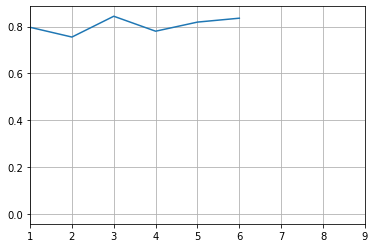

In [20]:
reducedData = numpy.load('labeled_reduit_100dim.npy')
numberOfData = reducedData.shape[0]
dimensions = reducedData.shape[1]

#print(numberOfData, dimensions)

# normaliser les données d'entrée entre 0 et 1 pour toutes les dimensions.
X_train_reduced = minmax_scale(reducedData[ : -((numberOfData//4)), :]) # 1081 premières données
X_test_reduced = minmax_scale(reducedData[(numberOfData//4)*3 + 1 : ,  :]) # 360 dernières données

#print(X_train_reduced.shape[1])

compute_results(X_train_reduced, X_test_reduced)

Tenir compte du fait que l'on n'a pas beaucoup de données considérant le nombre de dimensions

2 et 6 layers ressortent souvent (impression?) possibilité d'avoir une genre d'interférence